In [1]:
import glob
import matplotlib as mpl
import matplotlib.colors 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.optimize as spopt
import scipy.stats as spstats

import populationevolution_v5 as popev

np.random.seed(42)
plt.style.use(('C:\\Users\\Nicholas Sherer\\.matplotlib\\Sherer_Thesis.mplstyle'))
%matplotlib inline

In [2]:
def logNbarplot(ax, pop):
    mu = pop.mutation_list.flatten()
    f = pop.fitness_list.flatten()
    N = pop.population_distribution
    xmesh, ymesh = np.meshgrid(np.arange(mu.size),-np.arange(f.size))
    xmesh = xmesh.ravel()
    ymesh = ymesh.ravel()
    logN = np.maximum(0,np.log(N.flatten()))
    bottom = np.zeros_like(logN)
    width=1
    depth=1
    ax.bar3d(xmesh, ymesh, bottom, width, depth, logN, shade=True);
    ax.view_init(elev = 45, azim=45);
    ax.set_xticklabels('{:2g}'.format(m) for m in mu);
    ax.set_yticks(-np.arange(f.size))
    ax.set_yticklabels(['{:2g}'.format(f_) for f_ in f], fontsize='medium')
    zticks = ax.get_zticks()
    ax.set_zticklabels('{0:.2g}'.format(np.exp(v)) for v in zticks)
    
def logNvsfplot(ax, pop):
    f_list = pop.fitness_list.flatten()
    N_f = np.sum(pop.population_distribution, axis=1)
    ind = np.arange(f_list.size,0,-1)
    ax.bar(ind, N_f, width=.95)
    ax.set_yscale('log')
    ax.set_xticks(ind[::2]);
    ax.set_xticklabels(['{:1g}'.format(f) for f in f_list][::2]);
    ax.set_xlabel('fitness, $f$', fontsize=32)
    ax.set_ylabel('$N(f)$', fontsize=32)
    
def logNvsmuplot(ax, pop):
    mu_list = pop.mutation_list.flatten()
    N_mu = np.sum(pop.population_distribution, axis=0)
    ind = np.arange(mu_list.size)
    ax.bar(ind, N_mu, width=.95)
    ax.set_yscale('log')
    ax.set_xticks(ind[::2]);
    ax.set_xticklabels(['{:1g}'.format(mu) for mu in mu_list][::2]);
    ax.set_xlabel('mutation rate, $\mu$', fontsize=32)
    ax.set_ylabel('$N(\mu)$', fontsize=32)

In [3]:
def mean_df_dt(pop):
    f = pop.mean_fitness[:]
    t = np.arange(f.size)
    m, b = np.polyfit(t, f, 1)
    return m

# Load Data

In [4]:
fbvary_results = []
for file in glob.glob('evolved_mu_f_b_vary?datetime.datetime(2019, 4, *).hdf5'):
    fbvary_results.append(popev.PopulationReader(file))

favary_results = []
for file in glob.glob('evolved_mu_f_a_vary?datetime.datetime(2019, 4, *).hdf5'):
    favary_results.append(popev.PopulationReader(file))

delta_f_vary_results = []
for file in glob.glob('evolved_mu_delta_f_vary?datetime.datetime(2019, 4, *).hdf5'):
    delta_f_vary_results.append(popev.PopulationReader(file))
    
N_vary_results = []
for file in glob.glob('evolved_mu_N_vary?datetime.datetime(2019, 4, *).hdf5'):
    N_vary_results.append(popev.PopulationReader(file))

In [5]:
cd Thesis_Data_and_Figures/

E:\Documents\Python Evolution Simulation\Population Evolution Project Source Code\Thesis_Data_and_Figures


# Graphs of population distribution and trajectories for base parameter set

In [6]:
basepop = fbvary_results[5]
print('The parameters of the base population are delta_f: {},'
      ' M: {}, P_b: {}, P_a: {}, P_mu: {}, K: {}'.format(basepop.delta_fitness, basepop.mu_multiple,
                                                        basepop.fraction_beneficial, basepop.fraction_accurate,
                                                        basepop.fraction_mu2mu, basepop.pop_cap))

The parameters of the base population are delta_f: 0.03, M: 2, P_b: 0.0001, P_a: 0.0001, P_mu: 0.1, K: 1000000


Given a delta_f of .03 and a K of 1 million, we expect it would take about 450 generations for a new mutation increasing fitness by one step to fix after it invades the population

E:\Anaconda3\envs\imageprocessing_windows\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


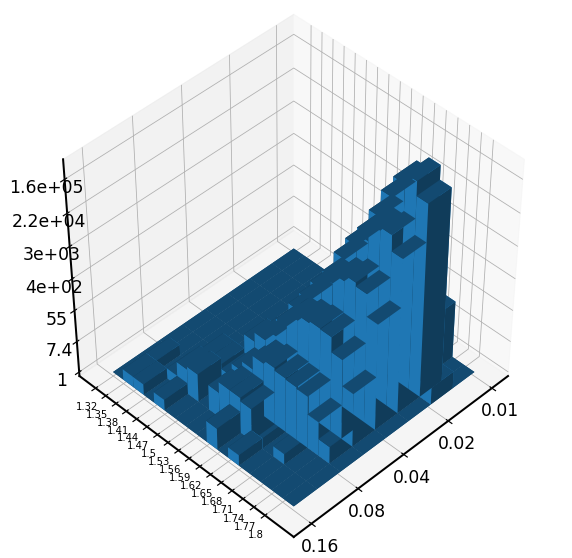

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
logNbarplot(ax, basepop(15000))
plt.savefig('traveling_wave_full_distribution.pdf')

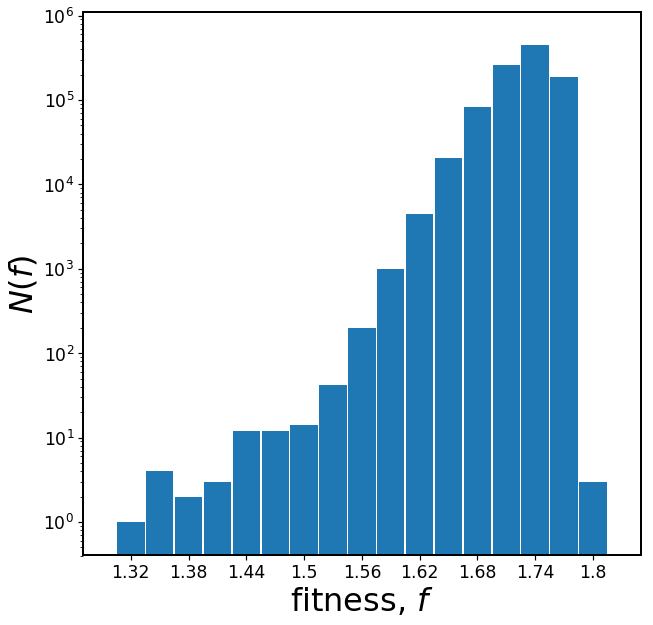

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
logNvsfplot(ax, basepop(15000))
plt.savefig('traveling_wave_f_distribution.pdf')

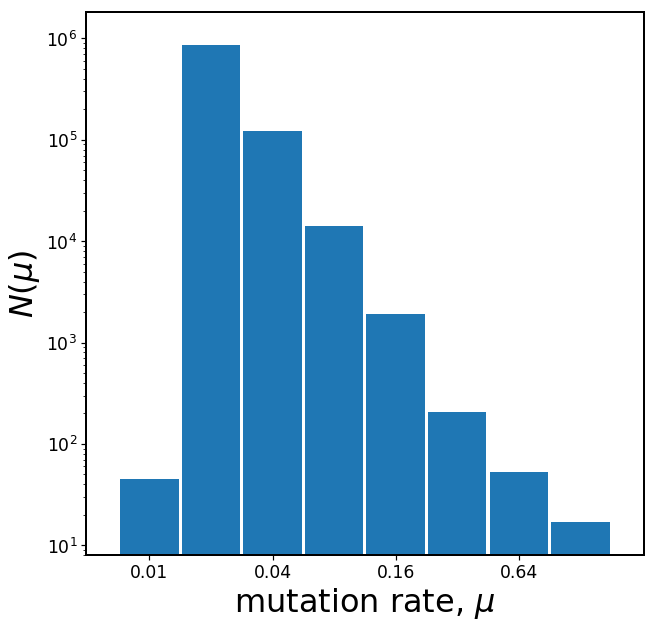

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
logNvsmuplot(ax, basepop(15000))
plt.savefig('traveling_wave_mu_distribution.pdf')

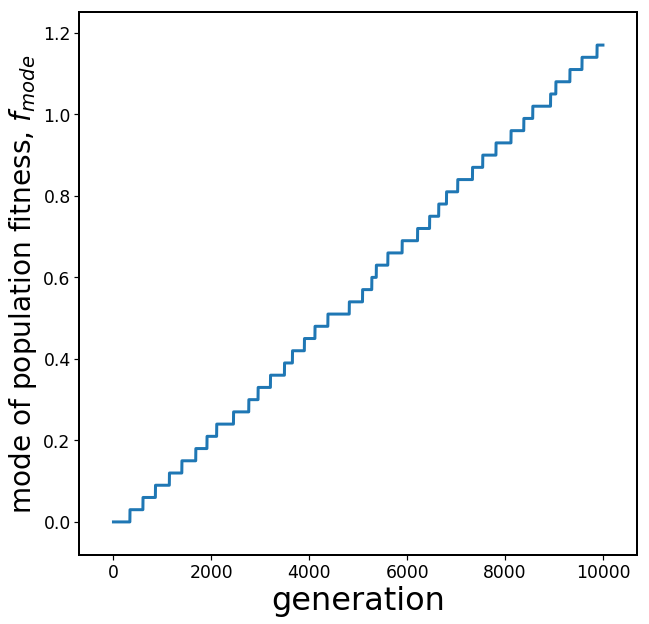

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.plot(basepop.mode_fitness[:10000], marker='');
ax.set_xlabel('generation', fontsize=32);
ax.set_ylabel('mode of population fitness, $f_{mode}$', fontsize=28);
plt.savefig('traveling_wave_f_evolution.pdf')

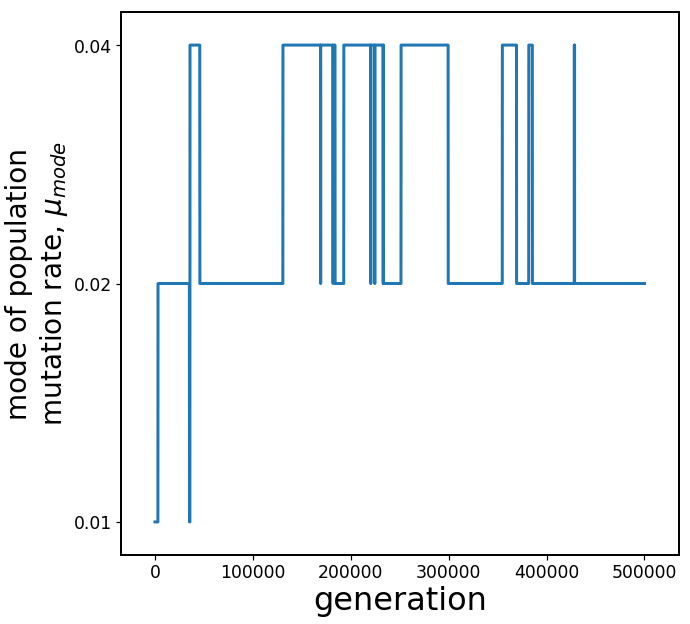

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.semilogy(basepop.mode_mutation_rate[:], marker='');
ax.minorticks_off()
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_yticks(np.unique(basepop.mode_mutation_rate[:]))
ax.set_xlabel('generation', fontsize=32);
ax.set_ylabel('mode of population\nmutation rate, $\mu_{mode}$', fontsize=28);
plt.savefig('traveling_wave_mu_evolution.pdf')

# Varying the probability of beneficial mutations

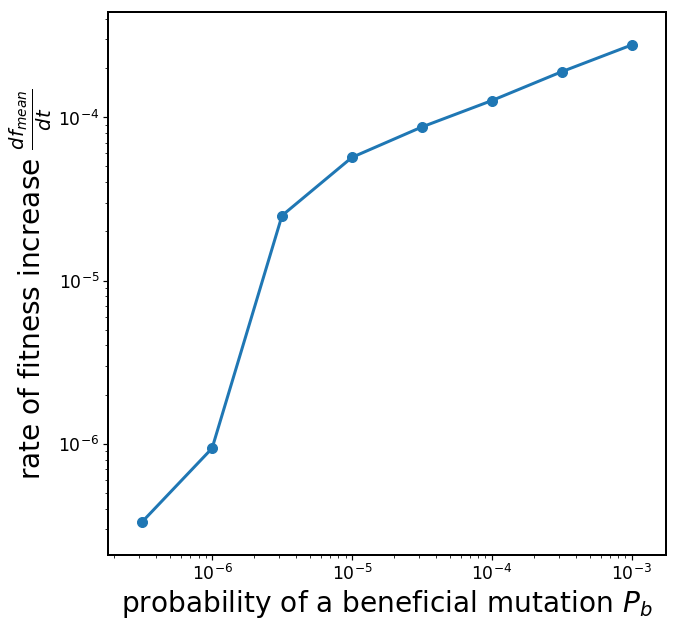

In [12]:
fig = plt.figure(figsize=(10,10))
plt.loglog([pop.fraction_beneficial for pop in fbvary_results],
           [mean_df_dt(pop) for pop in fbvary_results]);
plt.xlabel('probability of a beneficial mutation $P_{b}$', fontsize=28);
plt.ylabel(r'rate of fitness increase $\frac{df_{mean}}{dt}$', fontsize=28);
plt.savefig('df_dt_varying_P_b.pdf')

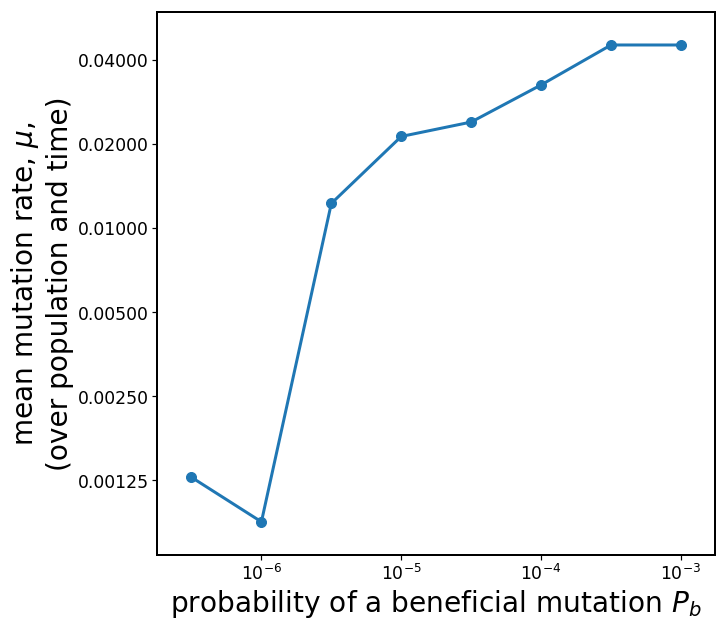

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.loglog([pop.fraction_beneficial for pop in fbvary_results],
         [np.mean(pop.mean_mutation_rate[:]) for pop in fbvary_results])
ax.minorticks_off()
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_yticks([.00125, .0025, .005, .01, .02, .04])
ax.set_xlabel('probability of a beneficial mutation $P_{b}$', fontsize=28);
ax.set_ylabel('mean mutation rate, $\mu$,\n(over population and time)', fontsize=28);
plt.savefig('mean_mu_varying_P_b.pdf')

# Varying the probability of accurate mutations

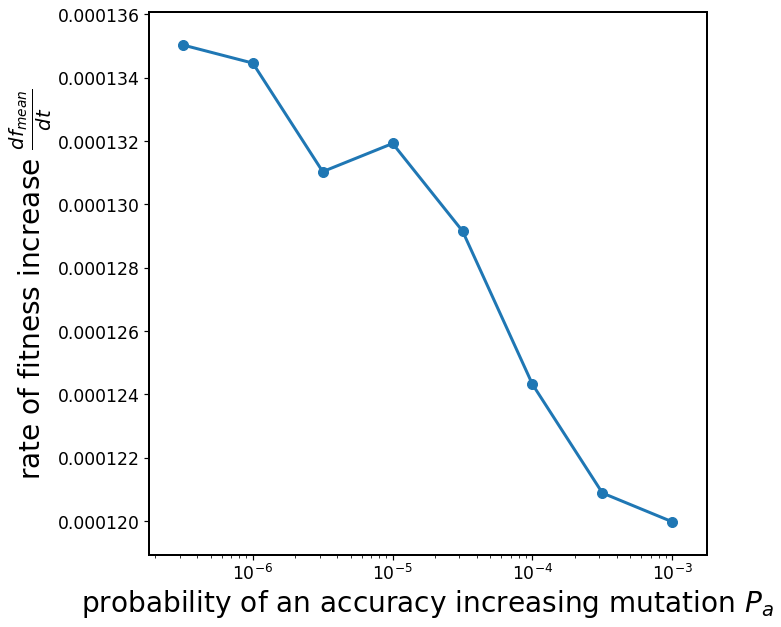

In [23]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.semilogx([pop.fraction_accurate for pop in favary_results],
           [mean_df_dt(pop) for pop in favary_results]);
ax.set_xlabel('probability of an accuracy increasing mutation $P_{a}$', fontsize=28);
ax.set_ylabel(r'rate of fitness increase $\frac{df_{mean}}{dt}$', fontsize=28);
plt.savefig('df_dt_varying_P_a.pdf')

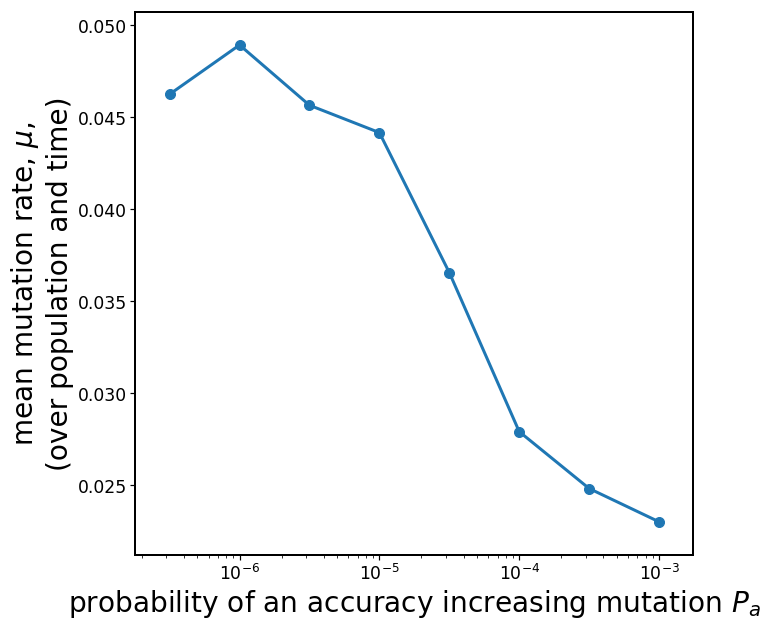

In [15]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.semilogx([pop.fraction_accurate for pop in favary_results],
           [np.mean(pop.mean_mutation_rate[:]) for pop in favary_results]);
ax.set_xlabel('probability of an accuracy increasing mutation $P_{a}$', fontsize=28);
ax.set_ylabel('mean mutation rate, $\mu$,\n(over population and time)', fontsize=28);
plt.savefig('mean_mu_varying_P_a.pdf')

# Varying $\Delta f$

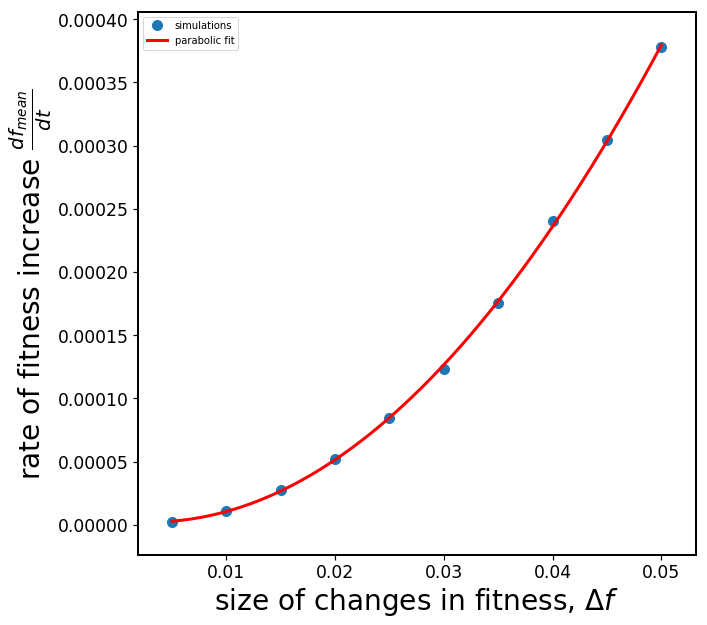

In [25]:
fig = plt.figure(figsize=(10,10))
plt.plot([pop.delta_fitness for pop in delta_f_vary_results],
           [mean_df_dt(pop) for pop in delta_f_vary_results], linestyle='',
         label='simulations');
def parabola(x, a, b, c):
    return a*x**2 + b*x + c
popt, pcov = spopt.curve_fit(parabola,
                             np.array([pop.delta_fitness for pop in delta_f_vary_results]),
                             np.array([mean_df_dt(pop) for pop in delta_f_vary_results]))
effs = np.linspace(.005,.05)
plt.plot(effs, parabola(effs,*popt), 'r', marker='', label='parabolic fit')
plt.xlabel('size of changes in fitness, $\Delta f$', fontsize=28);
plt.ylabel(r'rate of fitness increase $\frac{df_{mean}}{dt}$', fontsize=28);
plt.legend()
plt.savefig('df_dt_varying_delta_f.pdf')

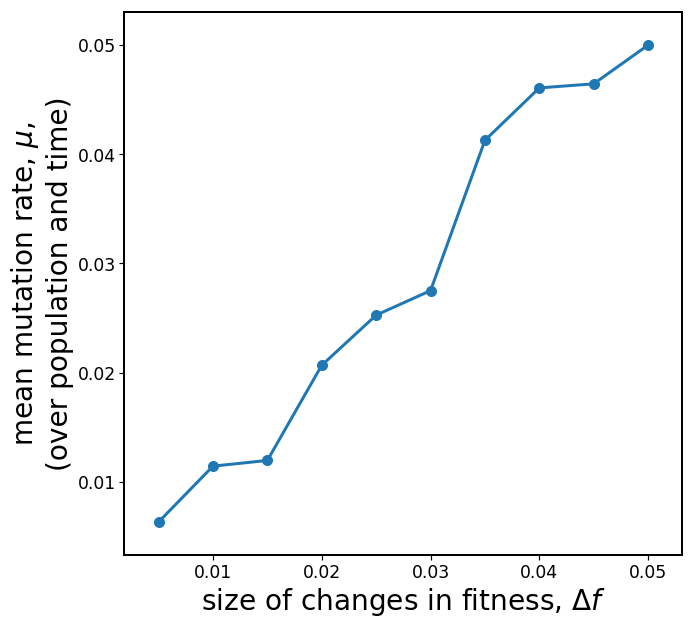

In [17]:
fig = plt.figure(figsize=(10,10))
plt.plot([pop.delta_fitness for pop in delta_f_vary_results],
           [np.mean(pop.mean_mutation_rate[:]) for pop in delta_f_vary_results]);
plt.xlabel('size of changes in fitness, $\Delta f$', fontsize=28);
plt.ylabel('mean mutation rate, $\mu$,\n(over population and time)', fontsize=28);
plt.savefig('mean_mu_varying_delta_f.pdf')

# Varying N

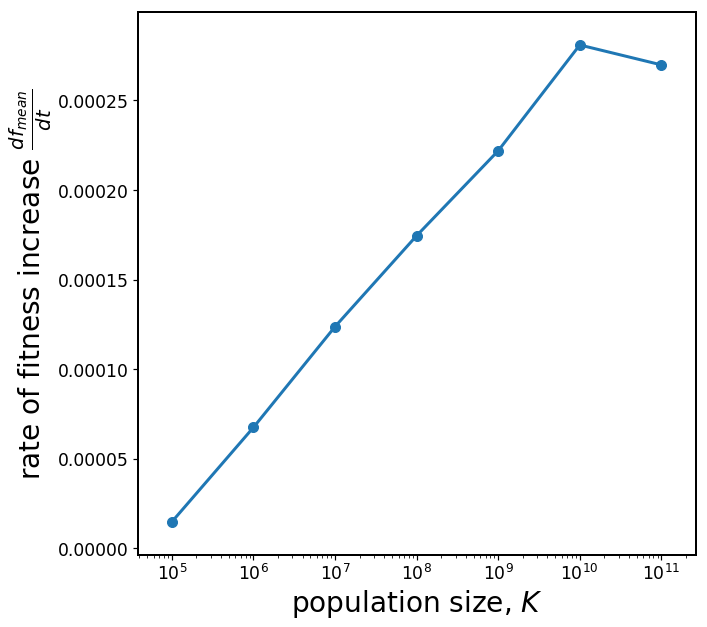

In [24]:
fig = plt.figure(figsize=(10,10))
plt.semilogx([pop.pop_cap for pop in N_vary_results][1:],
           [mean_df_dt(pop) for pop in N_vary_results][1:]);
plt.xlabel('population size, $K$', fontsize=28);
plt.ylabel(r'rate of fitness increase $\frac{df_{mean}}{dt}$', fontsize=28);
plt.savefig('df_dt_varying_K.pdf')

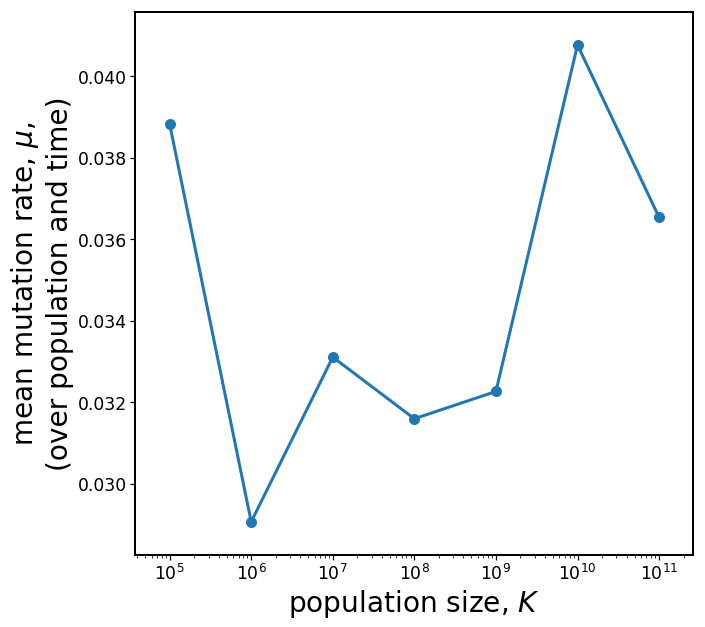

In [22]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.semilogx([pop.pop_cap for pop in N_vary_results][1:],
           [np.mean(pop.mean_mutation_rate[:]) for pop in N_vary_results][1:]);
ax.set_xlabel('population size, $K$', fontsize=28);
ax.set_ylabel('mean mutation rate, $\mu$,\n(over population and time)', fontsize=28);
plt.savefig('mean_mu_varying_K.pdf')

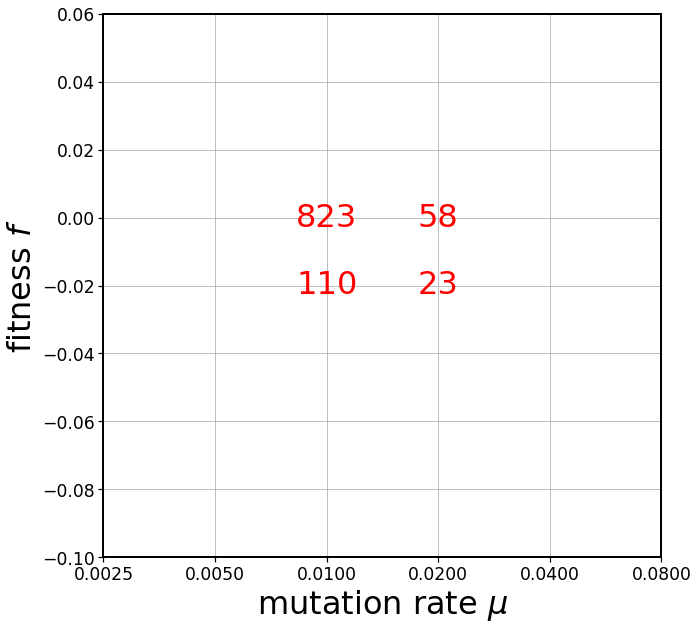

In [44]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_ylim(-.1,.06)
ax.set_yticks(np.linspace(-.1,.06,9))
ax.set_xlim(.01/4,.04)
ax.set_xscale('log')
ax.minorticks_off()
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks([.01/4, .01/2, .01, .02, .04, .08])
ax.grid(True)
ax.text(.01, 0, '823', ha='center', va='center', fontsize=32, color='red')
ax.text(.01, -.02, '110', ha='center', va='center', fontsize=32, color='red')
ax.text(.02, 0, '58', ha='center', va='center', fontsize=32, color='red')
ax.text(.02, -.02, '23', ha='center', va='center', fontsize=32, color='red')
ax.set_xlabel('mutation rate $\mu$', fontsize=32)
ax.set_ylabel('fitness $f$', fontsize=32)
plt.savefig('example_fitness_and_mu_layout.pdf')